In [2]:
#imports
from contextlib import contextmanager
from collections import namedtuple, defaultdict

import pandas as pd
import numpy as np
import scipy as sp

from polara.recommender.models import RecommenderModel, SVDModel, PopularityModel, RandomModel
from polara.recommender.data import RecommenderData
from polara.recommender.coldstart.data import ItemColdStartData

from polara.tools.printing import print_frames, suppress_stdout
from polara.lib.similarity import combine_similarity_data
from tools import get_bx_data

from evaluation import evaluate_hits
from models_sparse import FeatureSimilarityMixin
from models_sparse import HybridSVD, HybridSVDColdStart, ColdSimilarityMixin

from tqdm import tqdm_notebook

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [3]:
class ColdStartSimilarityDataModel(ColdSimilarityMixin, FeatureSimilarityMixin, ItemColdStartData): pass

In [4]:
class UserPopularityColdStart(RecommenderModel):
    def __init__(self, *args, **kwargs):
        super(UserPopularityColdStart, self).__init__(*args, **kwargs)
        self.method = 'MP'
        self.filter_seen = False # there are no seen items in cold-start recommendations

    def build(self):
        userid = self.data.fields.userid
        user_activity = self.data.training[userid].value_counts(sort=False)
        self.user_scores = user_activity.sort_values(ascending=False)

    def get_recommendations(self):
        topk = self.topk
        shape = (self.data.index.itemid.cold_start.shape[0], topk)
        top_users = self.user_scores.index[:topk].values
        top_users_array = np.lib.stride_tricks.as_strided(top_users, shape,
                                                          (0, top_users.itemsize))
        return top_users_array

class UserRandomColdStart(RecommenderModel):
    def __init__(self, *args, **kwargs):
        seed = kwargs.pop('seed', None)
        super(UserRandomColdStart, self).__init__(*args, **kwargs)
        self.method = 'RND'
        self.filter_seen = False # there are no seen items in cold-start recommendations

    def build(self):
        #repr_users = self.data.representative_users
        #if repr_users is None:
        #    repr_users = self.data.index.userid.training
        #self.repr_users = repr_users.new.values
        self.repr_users = self.data.index.userid.training.new.values

    def get_recommendations(self):
        repr_users = self.repr_users
        n_cold_items = self.data.index.itemid.cold_start.shape[0]
        shape = (n_cold_items, len(repr_users))
        users_matrix = np.lib.stride_tricks.as_strided(repr_users, shape,
                                                       (0, repr_users.itemsize))
        random_state = np.random.RandomState(seed) if seed else np.random
        random_users = np.apply_along_axis(random_state.choice, 1, users_matrix, self.topk, replace=False)
        return random_users

In [5]:
class ContentBasedColdStart(RecommenderModel):
    def __init__(self, *args, **kwargs):
        super(ContentBasedColdStart, self).__init__(*args, **kwargs)
        self.method = 'CB'

    def build(self):
        pass

    def get_recommendations(self):
        item_similarity_scores = self.data.cold_items_similarity
        
        user_item_matrix = self.get_training_matrix()
        user_item_matrix.data = np.ones_like(user_item_matrix.data)
        
        scores = item_similarity_scores.dot(user_item_matrix.T).tocsr()
        top_similar_users = self.get_topk_elements(scores).astype(np.intp)
        return top_similar_users

In [6]:
class PureSVDColdStart(SVDModel):
    def __init__(self, *args, **kwargs):
        super(PureSVDColdStart, self).__init__(*args, **kwargs)
        self.method = 'PureSVD+CB'
        self.filter_seen = False # there are no seen items in cold-start recommendations
        self.p = None
        
    def build(self, *args, **kwargs):
        super(PureSVDColdStart, self).build(*args, return_factors=True, **kwargs)

    def get_recommendations(self):
        userid = self.data.fields.userid
        itemid = self.data.fields.itemid
                
        user_factors = self.factors[userid]        
        item_factors = self.factors[itemid]
        s1 = np.reciprocal(self.factors['singular_values'])
                
        similarity_matrix = self.data.cold_items_similarity
        cold_factors = similarity_matrix.dot(item_factors * s1[None, :])
        cold_factors /= np.linalg.norm(cold_factors, axis=0)[None, :]
        user_factors = user_factors / np.linalg.norm(user_factors, axis=0)[None, :]
        
        # computes cosine similarity between fake "cold" users and representative users
        scores = cold_factors.dot(user_factors.T)
        top_similar_users = self.get_topk_elements(scores)
        return top_similar_users

In [7]:
class PureSVDColdStart2(PureSVDColdStart):
    def __init__(self, *args, **kwargs):
        super(PureSVDColdStart, self).__init__(*args, **kwargs)
        self.method = 'PureSVD+CB2'

    def get_recommendations(self):
        userid = self.data.fields.userid
                
        user_factors = self.factors[userid]        
        s1 = np.reciprocal(self.factors['singular_values'])
                
        cold_similarity_matrix = self.data.cold_items_similarity
        
        user_item_matrix = self.get_training_matrix()
        user_item_matrix.data = np.ones_like(user_item_matrix.data)
        similarity_scores = cold_similarity_matrix.dot(user_item_matrix.T).tocsr()
                
        scores = similarity_scores.dot(user_factors).dot(user_factors.T)
        top_similar_users = self.get_topk_elements(scores)
        return top_similar_users

In [8]:
class HybridSVDColdStart2(HybridSVDColdStart):
    def __init__(self, *args, **kwargs):
        super(HybridSVDColdStart, self).__init__(*args, **kwargs)
        self.method = 'HybridSVD2'

    def get_recommendations(self):
        userid = self.data.fields.userid
                
        user_factors = self.factors[userid]        
        s1 = np.reciprocal(self.factors['singular_values'])
                
        cold_similarity_matrix = self.data.cold_items_similarity
        
        user_item_matrix = self.get_training_matrix()
        user_item_matrix.data = np.ones_like(user_item_matrix.data)
        similarity_scores = cold_similarity_matrix.dot(user_item_matrix.T).tocsr()
                
        scores = similarity_scores.dot(user_factors).dot(user_factors.T)
        top_similar_users = self.get_topk_elements(scores)
        return top_similar_users

# Preparing Data

In [9]:
bx_path = "datasets/BX-CSV-Dump.zip"

In [10]:
ratings, users, books = get_bx_data(bx_path, get_books=True, get_users=True)

In [8]:
implicit_data = ratings.query('rating==0').assign(rating=1)
valid_users = implicit_data.userid.value_counts().loc[lambda x: x<2000].index
implicit_data = implicit_data.query('userid in @valid_users')

In [9]:
valid_books = implicit_data.isbn.value_counts().loc[lambda x: x>1].index

In [10]:
bx_data = implicit_data.query('isbn in @valid_books')

In [11]:
books = (books[books.isbn.isin(bx_data.isbn.unique())]
         .set_index('isbn')
         .applymap(lambda x: [x,]))

missing_isbn = bx_data.isbn.drop_duplicates().loc[lambda x: ~x.isin(books.index)].values

books = books.append(pd.DataFrame(index=missing_isbn), ignore_index=False)
books.loc[missing_isbn, :] = books.loc[missing_isbn, :].applymap(lambda x: [])
books.index.name = 'isbn'

In [12]:
jw = 'jaccard-weighted'
jd = 'jaccard'
cs = 'cosine'
tc = 'tfidf-cosine'

sim_type = {'author':jd}
item_similarity = combine_similarity_data(books[sim_type.keys()], similarity_type=sim_type, weights=None)

In [13]:
similarities = {'userid': None, 'isbn': item_similarity}
sim_indices = {'userid': None, 'isbn': books.index}

# Quick test

In [14]:
seed = 42
data_model = ColdStartSimilarityDataModel(similarities, sim_indices, bx_data, 'userid', 'isbn', 'rating', seed=seed)

In [15]:
data_model.test_sample =  None # defines amount of representative users
data_model._repr_users = None

In [16]:
data_model.prepare()

Preparing data...
6410 unique userid's within 6777 holdout interactions were filtered. Reason: not in the training data.


In [17]:
test_data = (data_model.test.evalset
             .groupby('isbn_cold', sort=False, as_index=False, group_keys=False)
             .apply(lambda x: x.sample(n=1, random_state=np.random.RandomState(seed)))
             .sort_values('isbn_cold'))

In [ ]:
# create recommenders
cb = ContentBasedColdStart(data_model)
mpop = UserPopularityColdStart(data_model)
rndm = UserRandomColdStart(data_model, seed=seed)
hsvd = HybridSVDColdStart(data_model)
psvd = PureSVDColdStart(data_model)

In [19]:
cb.build()

In [20]:
evaluate_hits(test_data, 'isbn_cold', 'userid', cb.recommendations).getnnz(axis=1).mean()

0.083962211414835938

In [66]:
evaluate_hits(test_data, 'isbn_cold', 'userid', cb.recommendations).getnnz(axis=1).mean()

0.083962211414835938

In [20]:
evaluate_hits(test_data, 'isbn_cold', 'userid', cb.recommendations).getnnz(axis=1).mean()

0.084465313880038015

In [47]:
mpop.build()

In [22]:
evaluate_hits(test_data, 'isbn_cold', 'userid', mpop.recommendations).getnnz(axis=1).mean()

0.032925261333780535

In [35]:
hsvd.rank = 200
hsvd.features_weight = 0.999
hsvd.build()

HybridSVD training time: 22.4671111107s


In [36]:
evaluate_hits(test_data, 'isbn_cold', 'userid', hsvd.recommendations).getnnz(axis=1).mean()

0.073117558276035555

In [23]:
psvd.rank = 10
psvd.build()

PureSVD+CB training time: 0.83873796463s


In [24]:
evaluate_hits(test_data, 'isbn_cold', 'userid', psvd.recommendations).getnnz(axis=1).mean()

0.044608418581251051

In [22]:
psvd2 = PureSVDColdStart2(data_model)

In [38]:
psvd2.rank = 1000
psvd2.build()

PureSVD+CB2 training time: 231.428905964s


In [34]:
evaluate_hits(test_data, 'isbn_cold', 'userid', psvd2.recommendations).getnnz(axis=1).mean()

0.080440494158421375

In [39]:
rr = range(50, 1001, 50)
res2 = []
for r in reversed(rr):
    psvd2.factors['userid'] = psvd2.factors['userid'][:, :r]
    psvd2._recommendations = None
    res2.append(evaluate_hits(test_data, 'isbn_cold', 'userid', psvd2.recommendations).getnnz(axis=1).mean())

res2 = list(reversed(res2))

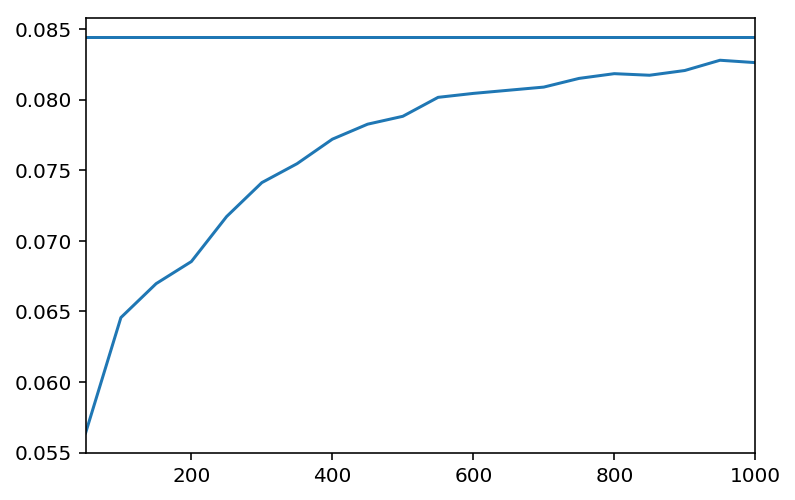

In [42]:
import matplotlib.pyplot as plt
pd.Series(index=rr, data=res2).plot()
plt.axhline(0.0844)

In [44]:
hsvd2 = HybridSVDColdStart2(data_model)

In [62]:
hsvd2.rank = 1000
hsvd2.build()

HybridSVD2 training time: 263.023324013s


In [46]:
evaluate_hits(test_data, 'isbn_cold', 'userid', hsvd2.recommendations).getnnz(axis=1).mean()

0.080999496897534801

In [63]:
rh = range(50, 1001, 50)
resh = []
for r in reversed(rh):
    hsvd2.factors['userid'] = hsvd2.factors['userid'][:, :r]
    hsvd2._recommendations = None
    resh.append(evaluate_hits(test_data, 'isbn_cold', 'userid', hsvd2.recommendations).getnnz(axis=1).mean())

resh = list(reversed(resh))

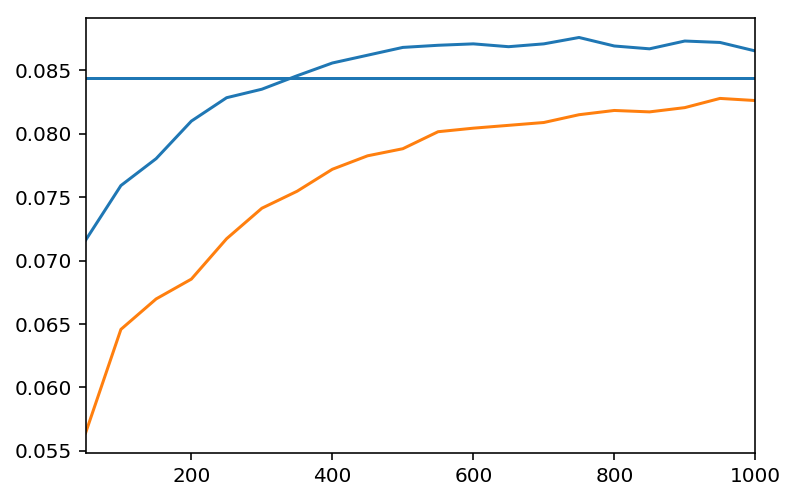

In [64]:
pd.Series(index=rh, data=resh).plot()
pd.Series(index=rr, data=res2).plot()
plt.axhline(0.0844)

# Experiments

In [66]:
def replicate_models(constructor, n, *args, **kwargs):
    config = kwargs.pop('config', [])
    replicas = [constructor(*args, **kwargs) for i in xrange(n)]
    try_set_config(replicas, config)
    return replicas

In [67]:
def build_models(models, config=None, verbose=False):
    try_set_config(models, config)
    for model in models:
        model.verbose = verbose
        model.build()

def try_set_config(models, config, force=False):
    if config is None:
        return
    for model, model_config in zip(models, config):
        if not model_config:
            continue
        for k, v in model_config.iteritems():
            if hasattr(model, k) or force:
                setattr(model, k, v)
            else:
                if model.vebose:
                    msg = 'Unable to set {} attribute for model {}'
                    print msg.format(k, model)

def set_models_attribute(models, attr_name, attr_val):
    for model in models:
        setattr(model, attr_name, attr_val)

def validate_model_settings(models, config, attr_name, no_attr_action):
    valid_models = []
    valid_config = []
    other_models = []
    other_config = []
    config = config or [None]*len(models)
    for i, model in enumerate(models):
        if not hasattr(model, attr_name):
            if no_attr_action is 'ignore':
                pass
            elif no_attr_action is 'process':
                other_models.append(model)
                other_config.append(config[i])
            elif no_attr_action is 'raise':
                raise AttributeError('Model {} has no {} dependence'.format(attr_name, model.method))
            else:
                raise ValueError('Unrecognized value for no_rank argument.')
        else:
            valid_models.append(model)
            valid_config.append(config[i])
    return (valid_models, valid_config), (other_models, other_config)

In [68]:
def evaluator(test_data, key, target):
    def eval_func(model, metrics):
        scores = {}
        recommendations = model.recommendations[..., :model.topk]
        hits = evaluate_hits(test_data, key, target, recommendations)
        if 'HR' in metrics:
            # calculate hit rate
            # only the fact of hits is accounted
            hit_rate = (hits.getnnz(axis=1) > 0).mean()
            scores['HR'] = hit_rate
        if 'MRR' in metrics:
            # calculate hit reciprocal rank
            hits.data = 1. / hits.data
            # only single best ranked reco is accounted
            scores['MRR'] = hits.max(axis=1).mean()
        if 'COV' in metrics:
            # assortment coverage
            scores['COV'] = np.unique(recommendations).size
        return scores
    return eval_func

def evaluate_models(models, metrics, eval_func):
    res = {}
    for model in models:
        eval_func = eval_func or model.__class__.evaluate # breaks if model has custom evalute() method
        res[model.method] = eval_func(model, metrics)
    return res

In [69]:
def run_cv_experiment(models, data_model, metrics, param_tuple, models_configuration=None, no_param_action='raise', verbose=False, folds=None):
    cv_results = defaultdict(lambda: defaultdict(dict))
    folds = folds or range(1, int(1 / data_model.test_ratio)+1)
    data_model.verbose = verbose
    param_name, param_vals = param_tuple
    
    param_vals_sorted = list(reversed(sorted(param_vals))) # avoids recomputations when possible
    (valid_models, valid_config), (other_models, other_config) = validate_model_settings(models, models_configuration, param_name, no_param_action)
        
    for fold in tqdm_notebook(folds, desc='fold'):
        data_model.test_fold = fold
        data_model.prepare()
        
        test_data = (data_model.test.evalset
                     .groupby('isbn_cold', sort=False, as_index=False, group_keys=False)
                     .apply(lambda x: x.sample(n=1, random_state=np.random.RandomState(seed)))
                     .sort_values('isbn_cold'))

        eval_func = evaluator(test_data, 'isbn_cold', 'userid')
            
        if other_models:
            build_models(other_models, config=other_config, verbose=verbose)
            other_scores = evaluate_models(other_models, metrics, eval_func)
            key = 'no_{}'.format(param_name)
            cv_results[fold][key].update(other_scores)

        set_models_attribute(valid_models, param_name, max(param_vals)) # avoids recomputations when possible
        build_models(valid_models, config=valid_config, verbose=verbose)
        for param_val in param_vals_sorted:
            set_models_attribute(valid_models, param_name, param_val)
            valid_scores = evaluate_models(valid_models, metrics, eval_func)
            cv_results[fold][param_val] = valid_scores

    return cv_results

In [70]:
def get_results_dataframe(cv_results, param_tuple, folds=None):
    df_from_dict = pd.DataFrame.from_dict
    param_name, param_vals = param_tuple
    param_vals = param_vals or ['no_{}'.format(param_name)]
    result = pd.concat({(i, j): df_from_dict(cv_results[i][j]) for i, p in cv_results.iteritems() for j in p if j in param_vals}, names=['fold', param_name]).unstack()
    return result

UPDATE

In [72]:
features_weights = [0.999, 0.5, 0.1]
hybrid_config = [{'features_weight':w, 'method': r'HybridSVD ($\alpha={}$)'.format(w)} for w in features_weights]
hybrids = replicate_models(HybridSVDColdStart2, len(features_weights), data_model, config=hybrid_config)

psvd2.method = 'PureSVD+CB'

models = [psvd2] + hybrids
models_config = [{'topk':10}]*len(models)

for model in models:
    print model.method,

PureSVD+CB HybridSVD ($\alpha=0.999$) HybridSVD ($\alpha=0.5$) HybridSVD ($\alpha=0.1$)


In [73]:
metrics = 'HR MRR COV'.split()
ranks = [1, 5, 10, 15, 20, 30, 50, 75, 100, 125, 150, 200, 300, 500, 750, 1000, 1250, 1500]

cv_results = run_cv_experiment(models, data_model, metrics, ('rank', ranks), models_configuration=models_config, no_param_action='process', verbose=False)

A Jupyter Widget

In [79]:
rank_cv_results = get_results_dataframe(cv_results, ('rank', ranks))

In [80]:
rank_cv_results.to_csv('Coldstart_SVD_CV_results_BX_UPD.csv', index=True)

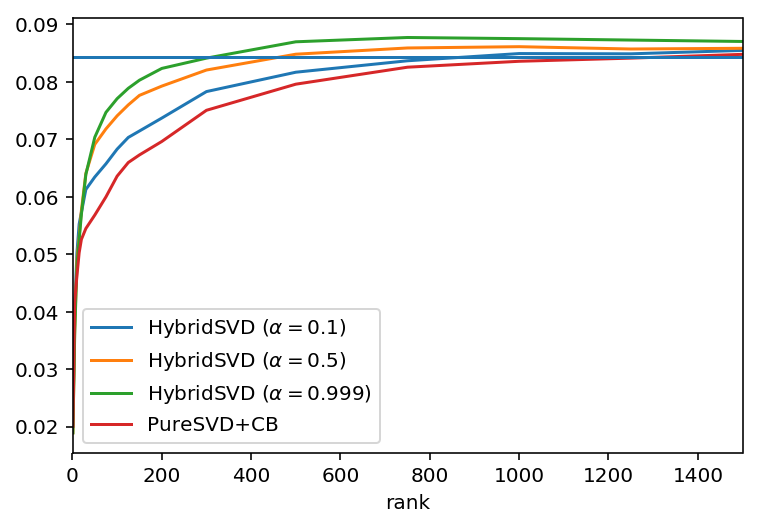

In [86]:
ax = rank_cv_results.xs('HR', 1, 1).mean(level='rank').plot(logx=False)
ax.axhline(0.0844)
ax.legend()

===END OF UPDATE===

In [37]:
baselines = [mpop, rndm, cb]

features_weights = [0.999, 0.5, 0.1]
hybrid_config = [{'features_weight':w, 'method': r'HybridSVD ($\alpha={}$)'.format(w)} for w in features_weights]
hybrids = replicate_models(HybridSVDColdStart, len(features_weights), data_model, config=hybrid_config)

models = baselines + [psvd] + hybrids
models_config = [{'topk':10}]*len(models)

for model in models:
    print model.method,

MP RND CB PureSVD+CB HybridSVD ($\alpha=0.999$) HybridSVD ($\alpha=0.5$) HybridSVD ($\alpha=0.1$)


In [ ]:
metrics = 'HR MRR COV'.split()
ranks = [1, 5, 10, 15, 20, 30, 50, 75, 100, 125, 150, 200, 300, 500, 750, 1000, 1250, 1500, 1750, 2000, 2500, 3200]

cv_results = run_cv_experiment(models, data_model, metrics, ('rank', ranks), models_configuration=models_config, no_param_action='process', verbose=False)

A Jupyter Widget

In [39]:
rank_cv_results = get_results_dataframe(cv_results, ('rank', ranks))
base_cv_results = get_results_dataframe(cv_results, ('rank', None))

In [40]:
rank_cv_results.to_csv('Coldstart_SVD_CV_results_BX.csv', index=True)

In [41]:
base_cv_results.to_csv('Coldstart_Baseline_CV_results_BX.csv', index=True)

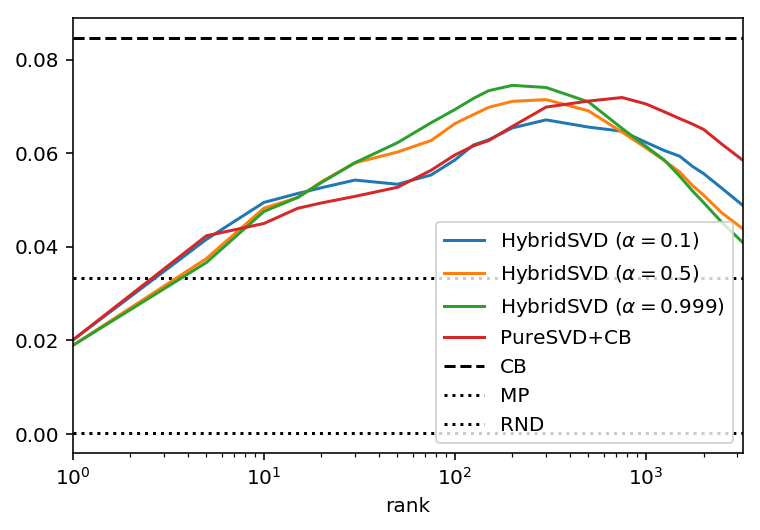

In [42]:
ax = rank_cv_results.xs('HR', 1, 1).mean(level='rank').plot(logx=True)

linestyles = {'CB': '--', 'RND': ':', 'MP': ':'}
colors = {'CB': '', 'RND': '', 'MP': ''}

for col, data in base_cv_results.xs('HR', 1, 1).mean(level='rank').iteritems():
    ax.hlines(y=data, xmin=1, xmax=3200, label=col, linestyles=linestyles[col])
ax.legend()

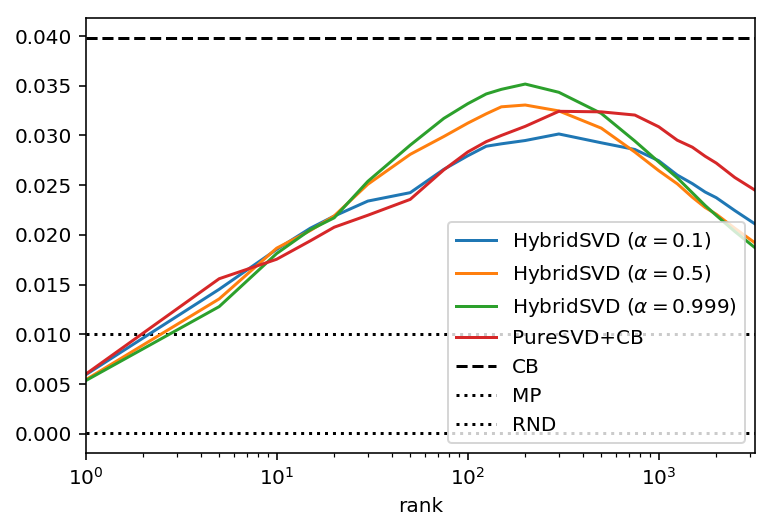

In [43]:
metric = 'MRR'
ax = rank_cv_results.xs(metric, 1, 1).mean(level='rank').plot(logx=True)

linestyles = {'CB': '--', 'RND': ':', 'MP': ':'}
colors = {'CB': '', 'RND': '', 'MP': ''}

for col, data in base_cv_results.xs(metric, 1, 1).mean(level='rank').iteritems():
    ax.hlines(y=data, xmin=1, xmax=3200, label=col, linestyles=linestyles[col])
ax.legend()

# FM

In [18]:
# %env OMP_NUM_THREADS=16
from polara.tools.graphlab.glwrapper import GraphlabFactorization
import graphlab as gl

In [19]:
class FMColdStart(GraphlabFactorization):
    def get_recommendations(self):
        userid = self.data.fields.userid
        itemid = self.data.fields.itemid
        
        cold_items_index = self.data.index.itemid.cold_start
        # prevent intersecting cold items index with known items
        lower_index_bound = self.data.index.itemid.training.new.max() + 1
        unseen_items_idx = cold_items_index.new.values + lower_index_bound
        
        new_item_data = gl.SFrame(self.item_side_info.loc[cold_items_index.old]
                                  .reset_index(drop=True)
                                  .assign(**{itemid:unseen_items_idx}))
        
        test_users = self.data.index.userid.training.new.values
        
        observation_idx = np.array([a.ravel() for a in np.broadcast_arrays(test_users, unseen_items_idx[:, None])], copy=False)
        new_observation_df = pd.DataFrame(observation_idx.T, columns=[userid, itemid], copy=False)
        new_observation = gl.SFrame(new_observation_df)
        
        scores = self.gl_model.predict(new_observation, new_item_data=new_item_data).to_numpy()
        top_similar_users = self.get_topk_elements(scores.reshape(-1, len(test_users)))
        return top_similar_users

## Quick test

In [20]:
fm = FMColdStart(data_model, item_side_info=books[sim_type.keys()])
fm.method = 'FM'
fm.binary_target = True
fm.solver = 'sgd'
fm.ranking_optimization = True
fm.seed = seed
fm.verbose = True

In [21]:
fm.ranking_regularization = 0.003
fm.regularization = 1e-10
fm.linear_regularization = 1e-10
fm.sgd_step_size = 0.3
fm.num_sampled_negative_examples = 30
fm.max_iterations = 30 # increased for better results
fm.rank = 10

In [22]:
fm.build()

This non-commercial license of GraphLab Create for academic use is assigned to evgeny.frolov@skolkovotech.ru and will expire on August 16, 2018.


[INFO] graphlab.cython.cy_server: GraphLab Create v2.1 started. Logging: /tmp/graphlab_server_1505980437.log


Recsys training: model = ranking_factorization_recommender

Preparing data set.

Data has 407120 observations with 44876 users and 71945 items.

Data prepared in: 0.686526s

Training ranking_factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 10       |

| regularization                 | L2 Regularization on Factors                     | 1e-10    |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 1e-10    |

| ranking_regularization         | Rank-based Regularization Weight                 | 0.003    |

| num_sampled_negative_examples  | # Negative Samples Considered per Observation    | 30       |

| binary_target                  | Assume Binary Targets                            | True     |

| side_data_factorization        | Assign Factors for Side Data                     | True     |

| sgd_step_size                  | Starting SGD Step Size                           | 0.3      |

| max_iterations                 | Maximum Number of Iterations                     | 30       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD (step size tuning: OFF).

Starting Optimization.

+---------+--------------+-------------------+-----------------------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training Predictive Error | Step Size   |

+---------+--------------+-------------------+-----------------------------------+-------------+

| Initial | 247us        | 1.62708           | 0.313266                          |             |

+---------+--------------+-------------------+-----------------------------------+-------------+

| 1       | 1.29s        | 1.62179           | 0.793069                          | 0.3         |

| 2       | 2.59s        | 1.50572           | 0.752919                          | 0.178381    |

| 3       | 3.88s        | 1.3158            | 0.648679                          | 0.131607    |

| 4       | 5.16s        | 1.35619           | 0.660277                          | 0.106066    |

| 5       | 6.46s        | 1.298             | 0.628773                          | 0.075446    |

| 6       | 7.74s        | 1.36533           | 0.663831                          | 0.0553341   |

| 7       | 9.03s        | 1.33005           | 0.65168                           | 0.0414501   |

| 8       | 10.32s       | 1.37368           | 0.677016                          | 0.0315336   |

| 9       | 11.60s       | 1.35472           | 0.67138                           | 0.0242746   |

| 10      | 12.89s       | 1.37783           | 0.685595                          | 0.0188615   |

| 11      | 14.19s       | 1.36998           | 0.683908                          | 0.0147664   |

| 12      | 15.48s       | 1.37773           | 0.68914                           | 0.0116326   |

| 13      | 16.76s       | 1.37484           | 0.688909                          | 0.00921184  |

| 14      | 18.04s       | 1.37883           | 0.691087                          | 0.00732741  |

| 15      | 19.33s       | 1.37647           | 0.690709                          | 0.00585087  |

| 16      | 20.62s       | 1.37757           | 0.691196                          | 0.0046875   |

| 17      | 21.92s       | 1.37692           | 0.691197                          | 0.00376649  |

| 18      | 23.20s       | 1.37568           | 0.689969                          | 0.00303432  |

| 19      | 24.49s       | 1.3752            | 0.690103                          | 0.00245016  |

| 20      | 25.75s       | 1.37397           | 0.689573                          | 0.00235769  |

| 21      | 27.04s       | 1.37339           | 0.689285                          | 0.00227297  |

| 22      | 28.32s       | 1.37264           | 0.688418                          | 0.00219504  |

| 23      | 29.61s       | 1.37179           | 0.688129                          | 0.00212306  |

| 24      | 30.91s       | 1.37151           | 0.687722                          | 0.00205637  |

| 25      | 32.20s       | 1.3704            | 0.687628                          | 0.00199436  |

| 26      | 33.49s       | 1.36956           | 0.68731                           | 0.00193655  |

| 27      | 34.78s       | 1.36968           | 0.687646                          | 0.0018825   |

| 28      | 36.06s       | 1.36857           | 0.68678                           | 0.0015404   |

| 29      | 37.37s       | 1.36761           | 0.686451                          | 0.00126167  |

| 30      | 38.67s       | 1.36716           | 0.68597                           | 0.0010343   |

+---------+--------------+-------------------+-----------------------------------+-------------+

Optimization Complete: Maximum number of passes through the data reached.

Computing final objective value and training Predictive Error.

Final objective value: 1.36866

Final training Predictive Error: 0.685339

FM training time: 42.474309s


In [24]:
evaluate_hits(test_data, 'isbn_cold', 'userid', fm.recommendations).getnnz(axis=1).mean()

0.01213035943876125

## Parameter search

In [23]:
from sklearn.model_selection import ParameterGrid

In [24]:
def run_parameter_search(model, data_model, metrics, params_grid, search_space_size=None, verbose=False, seed=None):
    grid_results = {}
    
    data_model.verbose = verbose
    data_model.update()
    test_data = (data_model.test.evalset
                 .groupby('isbn_cold', sort=False, as_index=False, group_keys=False)
                 .apply(lambda x: x.sample(n=1, random_state=np.random.RandomState(seed)))
                 .sort_values('isbn_cold'))

    eval_func = evaluator(test_data, 'isbn_cold', 'userid')
    
    if search_space_size:
        random_state = np.random.RandomState(seed) if seed else np.random
        param_choice = random_state.choice(len(params_grid), search_space_size, replace=False)
    else:
        param_choice = range(len(params_grid))

    for p in tqdm_notebook(param_choice, desc='params'):
        param_set = params_grid[p]
        build_models([model], config=[param_set], verbose=verbose)

        key = tuple([(''.join([s[0] for s in p.split('_')]), v) for p, v in param_set.iteritems()])
        grid_results[key] = eval_func(model, metrics)
    return grid_results

In [25]:
seed = 42
n_experiments = 120
metrics = 'HR MRR COV'.split()

### Exploration

In [26]:
params = {
          'ranking_regularization': [0.0001, 0.0003, 0.001, 0.003, 0.01, 0.03, 0.1, 0.3],
          'regularization':         [1e-10, 3e-10, 1e-9, 3e-9, 1e-8, 3e-8, 1e-7, 3e-7, 1e-6, 3e-6, 1e-5, 3e-5, 1e-4, 3e-4, 1e-3],
          'linear_regularization':  [1e-10, 3e-10, 1e-9, 3e-9, 1e-8, 3e-8, 1e-7, 3e-7, 1e-6, 3e-6, 1e-5, 3e-5, 3e-4, 3e-4, 1e-3],
          'sgd_step_size':          [0.01, 0.03, 0.01, 0.03, 0.1, 0.3],
          'num_sampled_negative_examples': [1, 3, 10, 30, 100],
          'max_iterations': [40],
          'rank': [10, 30, 100, 300]
         }

params_grid = ParameterGrid(params)
len(params_grid)

216000

In [27]:
# base FM settings
fm = FMColdStart(data_model, item_side_info=books[sim_type.keys()])
fm.method = 'FM'
fm.binary_target = True
fm.solver = 'sgd'
fm.ranking_optimization = True
fm.verbose = False
fm.seed = seed

In [ ]:
grid_results = run_parameter_search(fm, data_model, metrics, params_grid, n_experiments, verbose=False, seed=seed)

A Jupyter Widget

Recsys training: model = ranking_factorization_recommender

Recsys training: model = ranking_factorization_recommender

Recsys training: model = ranking_factorization_recommender

Recsys training: model = ranking_factorization_recommender

Recsys training: model = ranking_factorization_recommender

Recsys training: model = ranking_factorization_recommender

Recsys training: model = ranking_factorization_recommender

Recsys training: model = ranking_factorization_recommender

Recsys training: model = ranking_factorization_recommender

Recsys training: model = ranking_factorization_recommender

Recsys training: model = ranking_factorization_recommender

Recsys training: model = ranking_factorization_recommender

Recsys training: model = ranking_factorization_recommender

Recsys training: model = ranking_factorization_recommender

In [ ]:
grid_results_df = pd.DataFrame.from_dict(grid_results, orient='index')

In [ ]:
grid_results_df.to_csv('Coldstart_Random_Search_results_BX.csv', index=True)

In [40]:
grid_results_df.loc[lambda x: x.MRR > 0.9*x.MRR.max()]

HR  \
(sss, 0.1) (r, 3e-10) (rr, 0.0003) (r, 10)  (nsne, 3)  (lr, 3e-05) (mi, 40)  0.048242   
           (r, 3e-07) (rr, 0.003)  (r, 30)  (nsne, 10) (lr, 3e-05) (mi, 40)  0.044273   
           (r, 3e-06) (rr, 0.3)    (r, 30)  (nsne, 10) (lr, 3e-05) (mi, 40)  0.046733   
(sss, 0.3) (r, 1e-06) (rr, 0.03)   (r, 100) (nsne, 10) (lr, 3e-08) (mi, 40)  0.036838   

                                                                                  MRR  \
(sss, 0.1) (r, 3e-10) (rr, 0.0003) (r, 10)  (nsne, 3)  (lr, 3e-05) (mi, 40)  0.019532   
           (r, 3e-07) (rr, 0.003)  (r, 30)  (nsne, 10) (lr, 3e-05) (mi, 40)  0.020478   
           (r, 3e-06) (rr, 0.3)    (r, 30)  (nsne, 10) (lr, 3e-05) (mi, 40)  0.020210   
(sss, 0.3) (r, 1e-06) (rr, 0.03)   (r, 100) (nsne, 10) (lr, 3e-08) (mi, 40)  0.021277   

                                                                               COV  
(sss, 0.1) (r, 3e-10) (rr, 0.0003) (r, 10)  (nsne, 3)  (lr, 3e-05) (mi, 40)   1026  
           (r, 3e-07) (rr, 0.003)  (r, 30)  (nsne, 10) (lr, 3e-05) (mi, 40)   1221  
           (r, 3e-06) (rr, 0.3)    (r, 30)  (nsne, 10) (lr, 3e-05) (mi, 40)   1038  
(sss, 0.3) (r, 1e-06) (rr, 0.03)   (r, 100) (nsne, 10) (lr, 3e-08) (mi, 40)  15388

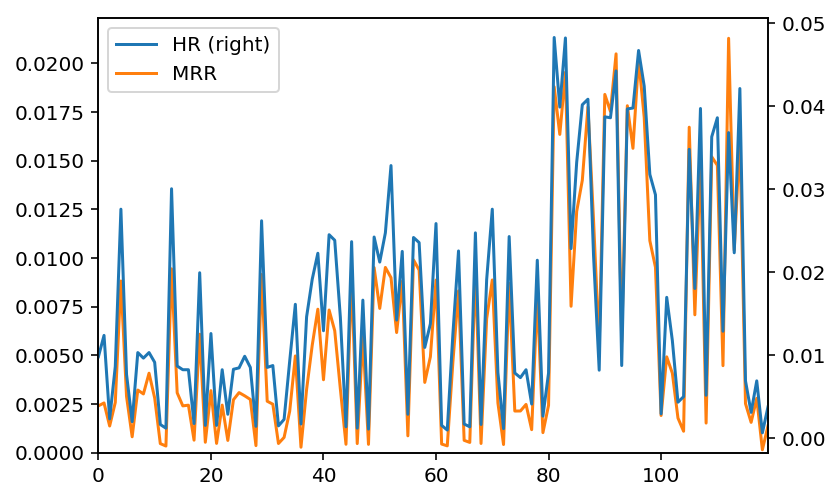

In [41]:
grid_results_df[['HR', 'MRR']].reset_index(drop=True).plot(secondary_y='HR', ylim=(0, None))

### Fine-tuning

In [42]:
refined_iters = {
          'ranking_regularization': [0.003],
          'regularization':         [3e-7],
          'linear_regularization':  [3e-5],
          'sgd_step_size':          [0.1],
          'num_sampled_negative_examples': [10],
          'max_iterations': [5, 10, 15, 20, 30, 40, 50, 75, 100],
          'rank': [30]
         }
refined_iters_grid = ParameterGrid(refined_iters)
len(refined_iters_grid)

9

In [43]:
iter_grid_results = run_parameter_search(fm, data_model, metrics, refined_iters_grid, verbose=False, seed=seed)

A Jupyter Widget

Recsys training: model = ranking_factorization_recommender

Recsys training: model = ranking_factorization_recommender

Recsys training: model = ranking_factorization_recommender

Recsys training: model = ranking_factorization_recommender

Recsys training: model = ranking_factorization_recommender

Recsys training: model = ranking_factorization_recommender

Recsys training: model = ranking_factorization_recommender

Recsys training: model = ranking_factorization_recommender

Recsys training: model = ranking_factorization_recommender

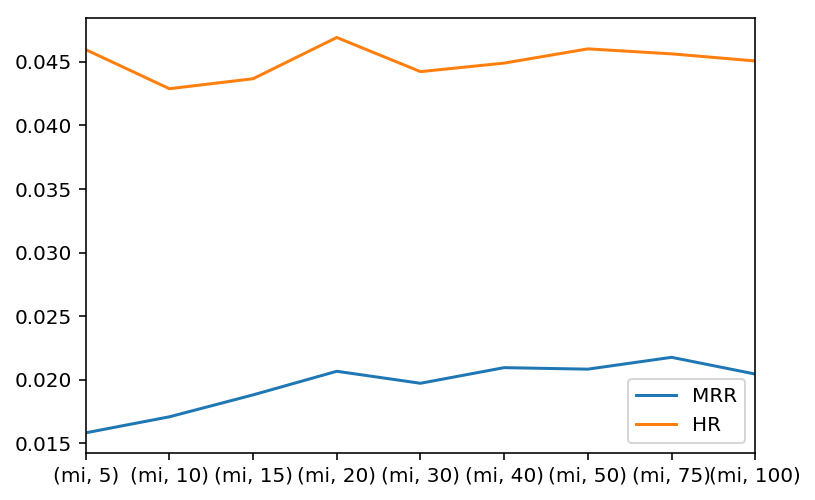

In [44]:
pd.DataFrame(iter_grid_results).T.reset_index(level=[0, 1, 2, 3, 4, 5], drop=True)[['MRR', 'HR']].plot()

In [45]:
refined_params = {
          'ranking_regularization': [0.001, 0.003, 0.01],
          'regularization':         [1e-7, 3e-7, 1e-6],
          'linear_regularization':  [1e-5, 3e-5, 1e-4],
          'sgd_step_size':          [0.1],
          'num_sampled_negative_examples': [5, 10, 15],
          'max_iterations': [75],
          'rank': [30]
         }
refined_params_grid = ParameterGrid(refined_params)
len(refined_params_grid)

81

In [ ]:
grid_results_refined = run_parameter_search(fm, data_model, metrics, refined_params_grid, verbose=False, seed=seed)

A Jupyter Widget

Recsys training: model = ranking_factorization_recommender

Recsys training: model = ranking_factorization_recommender

Recsys training: model = ranking_factorization_recommender

Recsys training: model = ranking_factorization_recommender

Recsys training: model = ranking_factorization_recommender

Recsys training: model = ranking_factorization_recommender

Recsys training: model = ranking_factorization_recommender

Recsys training: model = ranking_factorization_recommender

Recsys training: model = ranking_factorization_recommender

Recsys training: model = ranking_factorization_recommender

Recsys training: model = ranking_factorization_recommender

Recsys training: model = ranking_factorization_recommender

Recsys training: model = ranking_factorization_recommender

Recsys training: model = ranking_factorization_recommender

Recsys training: model = ranking_factorization_recommender

Recsys training: model = ranking_factorization_recommender

Recsys training: model = ranking_factorization_recommender

Recsys training: model = ranking_factorization_recommender

Recsys training: model = ranking_factorization_recommender

Recsys training: model = ranking_factorization_recommender

Recsys training: model = ranking_factorization_recommender

Recsys training: model = ranking_factorization_recommender

Recsys training: model = ranking_factorization_recommender

Recsys training: model = ranking_factorization_recommender

Recsys training: model = ranking_factorization_recommender

Recsys training: model = ranking_factorization_recommender

Recsys training: model = ranking_factorization_recommender

Recsys training: model = ranking_factorization_recommender

Recsys training: model = ranking_factorization_recommender

Recsys training: model = ranking_factorization_recommender

Recsys training: model = ranking_factorization_recommender

Recsys training: model = ranking_factorization_recommender

Recsys training: model = ranking_factorization_recommender

Recsys training: model = ranking_factorization_recommender

Recsys training: model = ranking_factorization_recommender

Recsys training: model = ranking_factorization_recommender

Recsys training: model = ranking_factorization_recommender

Recsys training: model = ranking_factorization_recommender

Recsys training: model = ranking_factorization_recommender

Recsys training: model = ranking_factorization_recommender

Recsys training: model = ranking_factorization_recommender

Recsys training: model = ranking_factorization_recommender

Recsys training: model = ranking_factorization_recommender

In [ ]:
grid_results_refined_df = pd.DataFrame.from_dict(grid_results_refined, orient='index')

In [54]:
grid_results_refined_df.loc[lambda x: x.MRR > 0.97*x.MRR.max()]

HR  \
(sss, 0.1) (r, 1e-07) (rr, 0.001) (r, 30) (nsne, 5)  (lr, 3e-05) (mi, 75)  0.048018   
                      (rr, 0.01)  (r, 30) (nsne, 5)  (lr, 3e-05) (mi, 75)  0.048801   
           (r, 3e-07) (rr, 0.001) (r, 30) (nsne, 5)  (lr, 3e-05) (mi, 75)  0.051149   
                      (rr, 0.003) (r, 30) (nsne, 10) (lr, 3e-05) (mi, 75)  0.047627   
                      (rr, 0.01)  (r, 30) (nsne, 5)  (lr, 3e-05) (mi, 75)  0.049695   
           (r, 1e-06) (rr, 0.001) (r, 30) (nsne, 5)  (lr, 3e-05) (mi, 75)  0.048354   
                      (rr, 0.003) (r, 30) (nsne, 5)  (lr, 3e-05) (mi, 75)  0.049025   
                      (rr, 0.01)  (r, 30) (nsne, 5)  (lr, 3e-05) (mi, 75)  0.049919   

                                                                                MRR  \
(sss, 0.1) (r, 1e-07) (rr, 0.001) (r, 30) (nsne, 5)  (lr, 3e-05) (mi, 75)  0.022207   
                      (rr, 0.01)  (r, 30) (nsne, 5)  (lr, 3e-05) (mi, 75)  0.022061   
           (r, 3e-07) (rr, 0.001) (r, 30) (nsne, 5)  (lr, 3e-05) (mi, 75)  0.022105   
                      (rr, 0.003) (r, 30) (nsne, 10) (lr, 3e-05) (mi, 75)  0.022051   
                      (rr, 0.01)  (r, 30) (nsne, 5)  (lr, 3e-05) (mi, 75)  0.022283   
           (r, 1e-06) (rr, 0.001) (r, 30) (nsne, 5)  (lr, 3e-05) (mi, 75)  0.022045   
                      (rr, 0.003) (r, 30) (nsne, 5)  (lr, 3e-05) (mi, 75)  0.022264   
                      (rr, 0.01)  (r, 30) (nsne, 5)  (lr, 3e-05) (mi, 75)  0.022712   

                                                                            COV  
(sss, 0.1) (r, 1e-07) (rr, 0.001) (r, 30) (nsne, 5)  (lr, 3e-05) (mi, 75)  1313  
                      (rr, 0.01)  (r, 30) (nsne, 5)  (lr, 3e-05) (mi, 75)  1320  
           (r, 3e-07) (rr, 0.001) (r, 30) (nsne, 5)  (lr, 3e-05) (mi, 75)  1295  
                      (rr, 0.003) (r, 30) (nsne, 10) (lr, 3e-05) (mi, 75)  1338  
                      (rr, 0.01)  (r, 30) (nsne, 5)  (lr, 3e-05) (mi, 75)  1306  
           (r, 1e-06) (rr, 0.001) (r, 30) (nsne, 5)  (lr, 3e-05) (mi, 75)  1239  
                      (rr, 0.003) (r, 30) (nsne, 5)  (lr, 3e-05) (mi, 75)  1241  
                      (rr, 0.01)  (r, 30) (nsne, 5)  (lr, 3e-05) (mi, 75)  1235

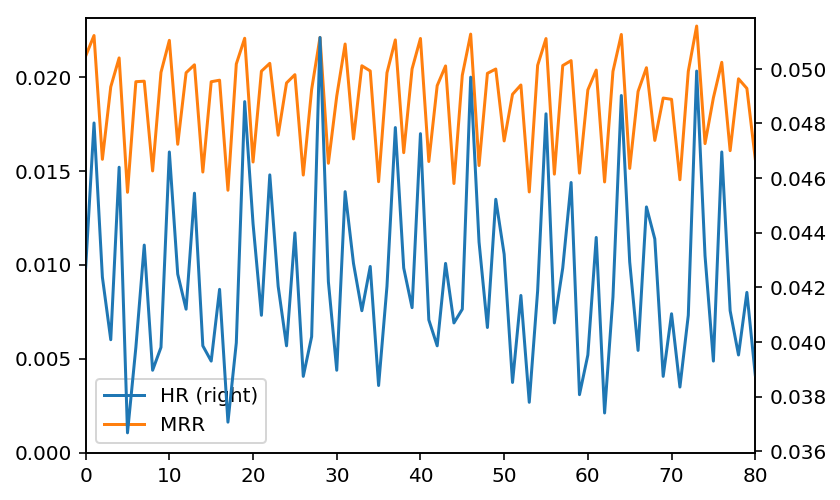

In [51]:
grid_results_refined_df[['HR', 'MRR']].reset_index(drop=True).plot(secondary_y='HR', ylim=(0, None))

### Final

In [55]:
final_params = {
                'sgd_step_size':                 0.1,
                'regularization':                1e-6,
                'ranking_regularization':        0.01,
                'rank':                          30,
                'num_sampled_negative_examples': 5,
                'linear_regularization':         3e-5,
                'max_iterations':                75,
         }

In [56]:
final_res = run_parameter_search(fm, data_model, metrics, [final_params], verbose=True, seed=seed)

A Jupyter Widget

Recsys training: model = ranking_factorization_recommender

Preparing data set.

Data has 407120 observations with 44876 users and 71945 items.

Data prepared in: 0.634992s

Training ranking_factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 30       |

| regularization                 | L2 Regularization on Factors                     | 1e-06    |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 3e-05    |

| ranking_regularization         | Rank-based Regularization Weight                 | 0.01     |

| num_sampled_negative_examples  | # Negative Samples Considered per Observation    | 5        |

| binary_target                  | Assume Binary Targets                            | True     |

| side_data_factorization        | Assign Factors for Side Data                     | True     |

| sgd_step_size                  | Starting SGD Step Size                           | 0.1      |

| max_iterations                 | Maximum Number of Iterations                     | 75       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD (step size tuning: OFF).

Starting Optimization.

+---------+--------------+-------------------+-----------------------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training Predictive Error | Step Size   |

+---------+--------------+-------------------+-----------------------------------+-------------+

| Initial | 200us        | 1.62686           | 0.313266                          |             |

+---------+--------------+-------------------+-----------------------------------+-------------+

| 1       | 532.129ms    | 1.39736           | 0.686001                          | 0.1         |

| 2       | 944.684ms    | 1.35521           | 0.67255                           | 0.0450175   |

| 3       | 1.43s        | 1.33026           | 0.660948                          | 0.0290468   |

| 4       | 1.97s        | 1.31943           | 0.655441                          | 0.0214405   |

| 5       | 2.38s        | 1.30993           | 0.651559                          | 0.0169911   |

| 6       | 2.91s        | 1.30124           | 0.648135                          | 0.014071    |

| 10      | 4.69s        | 1.27763           | 0.635832                          | 0.00833873  |

| 11      | 5.14s        | 1.27457           | 0.635131                          | 0.00756796  |

| 15      | 6.95s        | 1.2615            | 0.627545                          | 0.00552515  |

| 20      | 9.34s        | 1.24849           | 0.620127                          | 0.00413123  |

| 25      | 11.85s       | 1.23863           | 0.612423                          | 0.00329895  |

| 30      | 14.29s       | 1.23035           | 0.607596                          | 0.00274579  |

| 35      | 16.66s       | 1.22288           | 0.603945                          | 0.00235149  |

| 40      | 19.00s       | 1.21589           | 0.599594                          | 0.00205622  |

| 45      | 21.25s       | 1.20995           | 0.59705                           | 0.00182682  |

| 50      | 23.73s       | 1.20417           | 0.593043                          | 0.00164348  |

| 51      | 24.21s       | 1.20332           | 0.592215                          | 0.00161114  |

| 55      | 26.05s       | 1.19883           | 0.588937                          | 0.00149358  |

| 60      | 28.34s       | 1.1955            | 0.586558                          | 0.00135608  |

| 65      | 30.78s       | 1.19032           | 0.583925                          | 0.00109208  |

| 70      | 33.25s       | 1.18734           | 0.581996                          | 0.000868678 |

| 75      | 35.56s       | 1.18385           | 0.579254                          | 0.000824872 |

+---------+--------------+-------------------+-----------------------------------+-------------+

Optimization Complete: Maximum number of passes through the data reached.

Computing final objective value and training Predictive Error.

Final objective value: 1.18325

Final training Predictive Error: 0.578153

FM training time: 36.433687s



In [57]:
final_res

{(('sss', 0.1),
  ('r', 1e-06),
  ('rr', 0.01),
  ('r', 30),
  ('nsne', 5),
  ('mi', 75),
  ('lr', 3e-05)): {'COV': 1259,
  'HR': 0.050813348985410026,
  'MRR': 0.023172194138989379}}

Saving best config

In [86]:
pd.Series(dict(binary_target = True,
               solver = 'sgd',
               ranking_optimization = True,
               verbose = False,
               seed = seed,
               name = 'FM',
               **final_params)).to_csv('FM_BX_coldstart_best_config.csv')

## Cross-validation

In [ ]:
metrics = 'HR MRR COV'.split()
ranks = [1, 5, 10, 15, 20, 30, 50, 75, 100, 125, 150, 200, 300, 500, 750, 1000, 1250, 1500, 1750, 2000, 2500, 3200]

fm_cv_results = run_cv_experiment([fm], data_model, metrics, ('rank', ranks), verbose=False)

A Jupyter Widget

Recsys training: model = ranking_factorization_recommender

Recsys training: model = ranking_factorization_recommender

Recsys training: model = ranking_factorization_recommender

Recsys training: model = ranking_factorization_recommender

Recsys training: model = ranking_factorization_recommender

Recsys training: model = ranking_factorization_recommender

Recsys training: model = ranking_factorization_recommender

Recsys training: model = ranking_factorization_recommender

Recsys training: model = ranking_factorization_recommender

Recsys training: model = ranking_factorization_recommender

Recsys training: model = ranking_factorization_recommender

Recsys training: model = ranking_factorization_recommender

Recsys training: model = ranking_factorization_recommender

Recsys training: model = ranking_factorization_recommender

Recsys training: model = ranking_factorization_recommender

Recsys training: model = ranking_factorization_recommender

Recsys training: model = ranking_factorization_recommender

In [ ]:
fm_rank_cv_results = get_results_dataframe(fm_cv_results, ('rank', ranks))

In [ ]:
fm_rank_cv_results.to_csv('Coldstart_FM_CV_results_BX.csv')

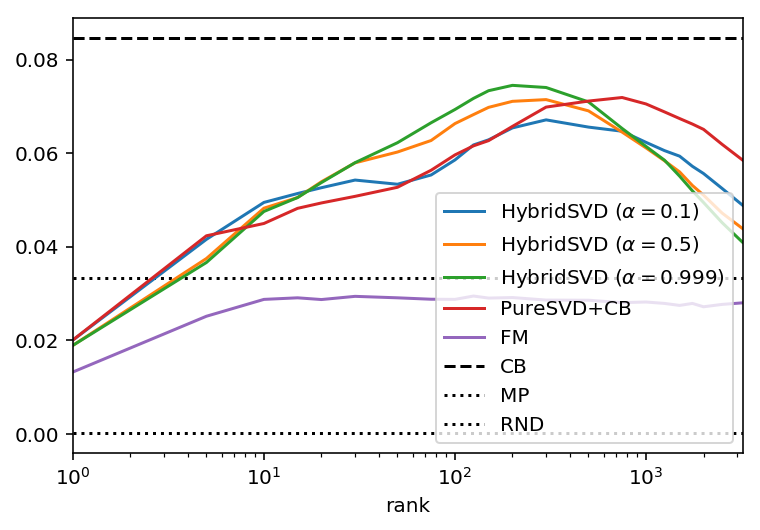

In [67]:
metric = 'HR'
ax = rank_cv_results.xs(metric, 1, 1).mean(level='rank').plot(logx=True)

fm_rank_cv_results.xs(metric, 1, 1).mean(level=1).plot(ax=ax, label='FM')

linestyles = {'CB': '--', 'RND': ':', 'MP': ':'}
colors = {'CB': '', 'RND': '', 'MP': ''}

for col, data in base_cv_results.xs(metric, 1, 1).mean(level='rank').iteritems():
    ax.hlines(y=data, xmin=1, xmax=3200, label=col, linestyles=linestyles[col])
ax.legend()

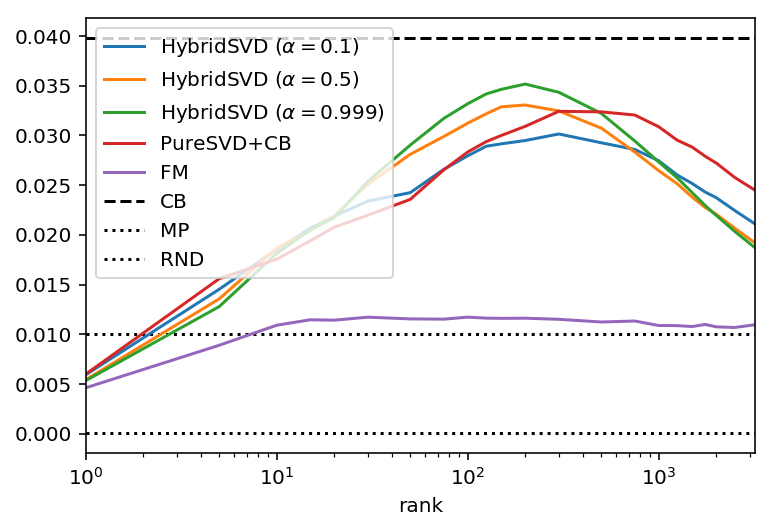

In [68]:
metric = 'MRR'
ax = rank_cv_results.xs(metric, 1, 1).mean(level='rank').plot(logx=True)

fm_rank_cv_results.xs(metric, 1, 1).mean(level=1).plot(ax=ax, label='FM')

linestyles = {'CB': '--', 'RND': ':', 'MP': ':'}
colors = {'CB': '', 'RND': '', 'MP': ''}

for col, data in base_cv_results.xs(metric, 1, 1).mean(level='rank').iteritems():
    ax.hlines(y=data, xmin=1, xmax=3200, label=col, linestyles=linestyles[col])
ax.legend()

In [69]:
rank_cv_results.loc[:, ('PureSVD+CB', 'MRR')].mean(level='rank').loc[lambda x: x == x.max()]

rank
300    0.032423
Name: (PureSVD+CB, MRR), dtype: float64

In [70]:
fm_rank_cv_results.loc[:, ('FM', 'MRR')].mean(level='rank').loc[lambda x: x == x.max()]

rank
100    0.011719
Name: (FM, MRR), dtype: float64

In [71]:
rank_cv_results.loc[:, (r'HybridSVD ($\alpha=0.1$)', 'MRR')].mean(level='rank').loc[lambda x: x == x.max()]

rank
300    0.030143
Name: (HybridSVD ($\alpha=0.1$), MRR), dtype: float64

In [72]:
rank_cv_results.loc[:, (r'HybridSVD ($\alpha=0.5$)', 'MRR')].mean(level='rank').loc[lambda x: x == x.max()]

rank
200    0.033055
Name: (HybridSVD ($\alpha=0.5$), MRR), dtype: float64

In [73]:
rank_cv_results.loc[:, (r'HybridSVD ($\alpha=0.999$)', 'MRR')].mean(level='rank').loc[lambda x: x == x.max()]

rank
200    0.035164
Name: (HybridSVD ($\alpha=0.999$), MRR), dtype: float64

# Top-N experiments

In [74]:
def sample_ci(df, coef=2.776, level=None): # 95% CI for sample
    return coef * df.std(level=level) / np.sqrt(df.shape[0])

In [78]:
baselines = [mpop, rndm, cb]

In [76]:
features_weights = [0.999, 0.5, 0.1]
hybrid_config = [{'features_weight':w, 'method': r'HybridSVD ($\alpha={}$)'.format(w)} for w in features_weights]
hybrids = replicate_models(HybridSVDColdStart, len(features_weights), data_model, config=hybrid_config)

In [80]:
hsvds = [hybrid_svd for hybrid_svd in hybrids if '0.1' not in hybrid_svd.method]

In [81]:
topk_models = baselines + [psvd, fm] + hsvds
models_config = [None]*len(baselines) + [{'rank':300}, {'rank':100}] + [{'rank':200}, {'rank':200}]

for model in topk_models:
    print model.method,

MP RND CB PureSVD+CB FM HybridSVD ($\alpha=0.999$) HybridSVD ($\alpha=0.5$)


In [82]:
topk_list = [1, 3, 10, 20, 30]

topk_cv_results = run_cv_experiment(topk_models, data_model, metrics, ('topk', topk_list), models_configuration=models_config, verbose=False)

A Jupyter Widget

Recsys training: model = ranking_factorization_recommender

Recsys training: model = ranking_factorization_recommender

Recsys training: model = ranking_factorization_recommender

Recsys training: model = ranking_factorization_recommender

Recsys training: model = ranking_factorization_recommender

In [83]:
topk_cv_results_df = get_results_dataframe(topk_cv_results, ('topk', topk_list))

In [84]:
topk_cv_results_df.to_csv('Coldstart_TopN_CV_results_BX.csv')

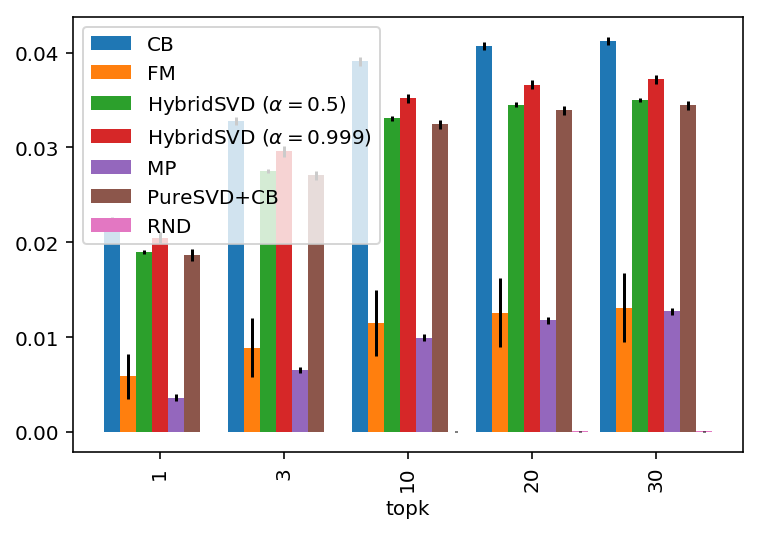

In [85]:
topk_cv_results_df.xs('MRR', 1, 1).mean(level='topk').plot.bar(yerr=sample_ci(topk_cv_results_df.xs('MRR', 1, 1), level='topk'), width=0.9, logy=False)

UPDATE

In [74]:
def sample_ci(df, coef=2.776, level=None): # 95% CI for sample
    return coef * df.std(level=level) / np.sqrt(df.shape[0])

In [75]:
features_weights = [0.999, 0.5, 0.1]
hybrid_config = [{'features_weight':w, 'method': r'HybridSVD ($\alpha={}$)'.format(w)} for w in features_weights]
hybrids = replicate_models(HybridSVDColdStart2, len(features_weights), data_model, config=hybrid_config)

In [76]:
hsvds = [hybrid_svd for hybrid_svd in hybrids if '0.1' not in hybrid_svd.method]

In [87]:
topk_models = [psvd2] + hsvds
models_config = [{'rank':1500}, {'rank':1500}, {'rank':1500}]

for model in topk_models:
    print model.method,

PureSVD+CB HybridSVD ($\alpha=0.999$) HybridSVD ($\alpha=0.5$)


In [88]:
topk_list = [1, 3, 10, 20, 30]

topk_cv_results = run_cv_experiment(topk_models, data_model, metrics, ('topk', topk_list), models_configuration=models_config, verbose=False)

A Jupyter Widget

In [89]:
topk_cv_results_df = get_results_dataframe(topk_cv_results, ('topk', topk_list))

In [90]:
topk_cv_results_df.to_csv('Coldstart_TopN_CV_results_BX_UPD.csv')

===END OF UPDATE===